# import packages

In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../models')

import numpy as np
import pandas as pd

import preprocessing
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns


# import pandas_profiling
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# load data

In [2]:
train,test, label_mapping = preprocessing.get_data(encoding="Label")
data_cols = list(train.columns[ train.columns != 'label' ])
train = preprocessing.normalize_data(train,data_cols)
test = preprocessing.normalize_data(test,data_cols)
x_train , x_test = preprocessing.preprocess(train,test,data_cols,"Robust",True)
# x_train = preprocessing.remove_outliers(train)

# train, test = None, None
y_train = x_train.label.values
y_test = x_test.label.values

d:\WorkSpace\GAN\GANs_for_Network_Intrusion_Data\NSL-KDD\notebooks
True


In [3]:
data_cols = list(x_train.columns[ x_train.columns != 'label' ])

to_drop = preprocessing.get_contant_featues(x_train,data_cols,threshold=0.995)
x_train.drop(to_drop, axis=1,inplace=True)
x_test.drop(to_drop, axis=1,inplace=True)

data_cols = list(x_train.columns[ x_train.columns != 'label' ])
print("Total data features : {}".format(len(data_cols)))

Total data features : 25


## Try to remove outliers without losing much data

In [4]:
Q1 = x_train.drop('label',axis=1).quantile(0.1)
Q3 = x_train.drop('label',axis=1).quantile(0.99)
IQR = Q3 - Q1
# print(IQR)

In [5]:
#Remove samples containing extreme values
mask = ~((x_train.drop('label',axis=1) < (Q1 - 1.5 * IQR)) | \
         (x_train.drop('label',axis=1) > (Q3 + 1.5 * IQR))).any(axis=1)

# data analysis

In [6]:
dos_df = x_train.query('label == 0')
print("Number of samples : {}".format(dos_df.shape[0]))
normal_df = x_train.query('label == 1')
print("# of samples : {}".format(normal_df.shape[0]))
probe_df = x_train.query('label == 2')
print("Number of probe attack samples : {}".format(probe_df.shape[0]))
r2l_df = x_train.query('label == 3')
print("Number of R2L samples : {}".format(r2l_df.shape[0]))
u2r_df = x_train.query('label == 4')
print("# of samples : {}".format(u2r_df.shape[0]))

Number of samples : 45927
# of samples : 67343
Number of probe attack samples : 11656
Number of R2L samples : 995
# of samples : 52


# classify nsl_kdd

In [7]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import pickle
import csv

import time

# classify preprocess data

In [8]:
df1 =  train.dropna()

In [9]:
# 处理数据中的字符值
label_encoder = LabelEncoder()
object_cols = df1.select_dtypes(include=['object']).columns

for col in object_cols:
    print(f"{col}: {df1[col].dtype}")
    df1[col] = label_encoder.fit_transform(df1[col])

df1.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,-0.005426,-0.010681,-0.004034,0.902520,0.000000,0.0,0.0,0.000000,0.0,...,-0.149771,-0.013509,0.000946,0.000708,0.006127,0.000000,0.000000,0.001842,0.00000,1
1,0.0,0.027664,-0.004616,0.002431,0.443658,0.000000,0.0,0.0,0.000000,0.0,...,0.425462,-0.058759,-0.004093,0.048518,0.055422,0.000000,0.000000,0.000000,0.00000,1
2,0.0,0.005282,0.000069,0.018581,-0.052693,0.000000,0.0,0.0,0.000000,0.0,...,0.455175,0.029288,0.001265,0.003542,0.000000,0.000000,0.156287,0.000000,0.00000,0
3,0.0,-0.017853,-0.012499,-0.012138,-0.024263,0.999103,0.0,0.0,0.008236,0.0,...,-0.437979,-0.030902,-0.002226,-0.000700,0.000068,0.000119,0.000163,0.000000,0.00002,1
4,0.0,-0.007132,-0.004639,-0.005147,0.284645,0.711973,0.0,0.0,0.113934,0.0,...,-0.009287,0.370241,0.021736,-0.000700,0.000000,0.000000,0.000000,0.000000,0.00000,1


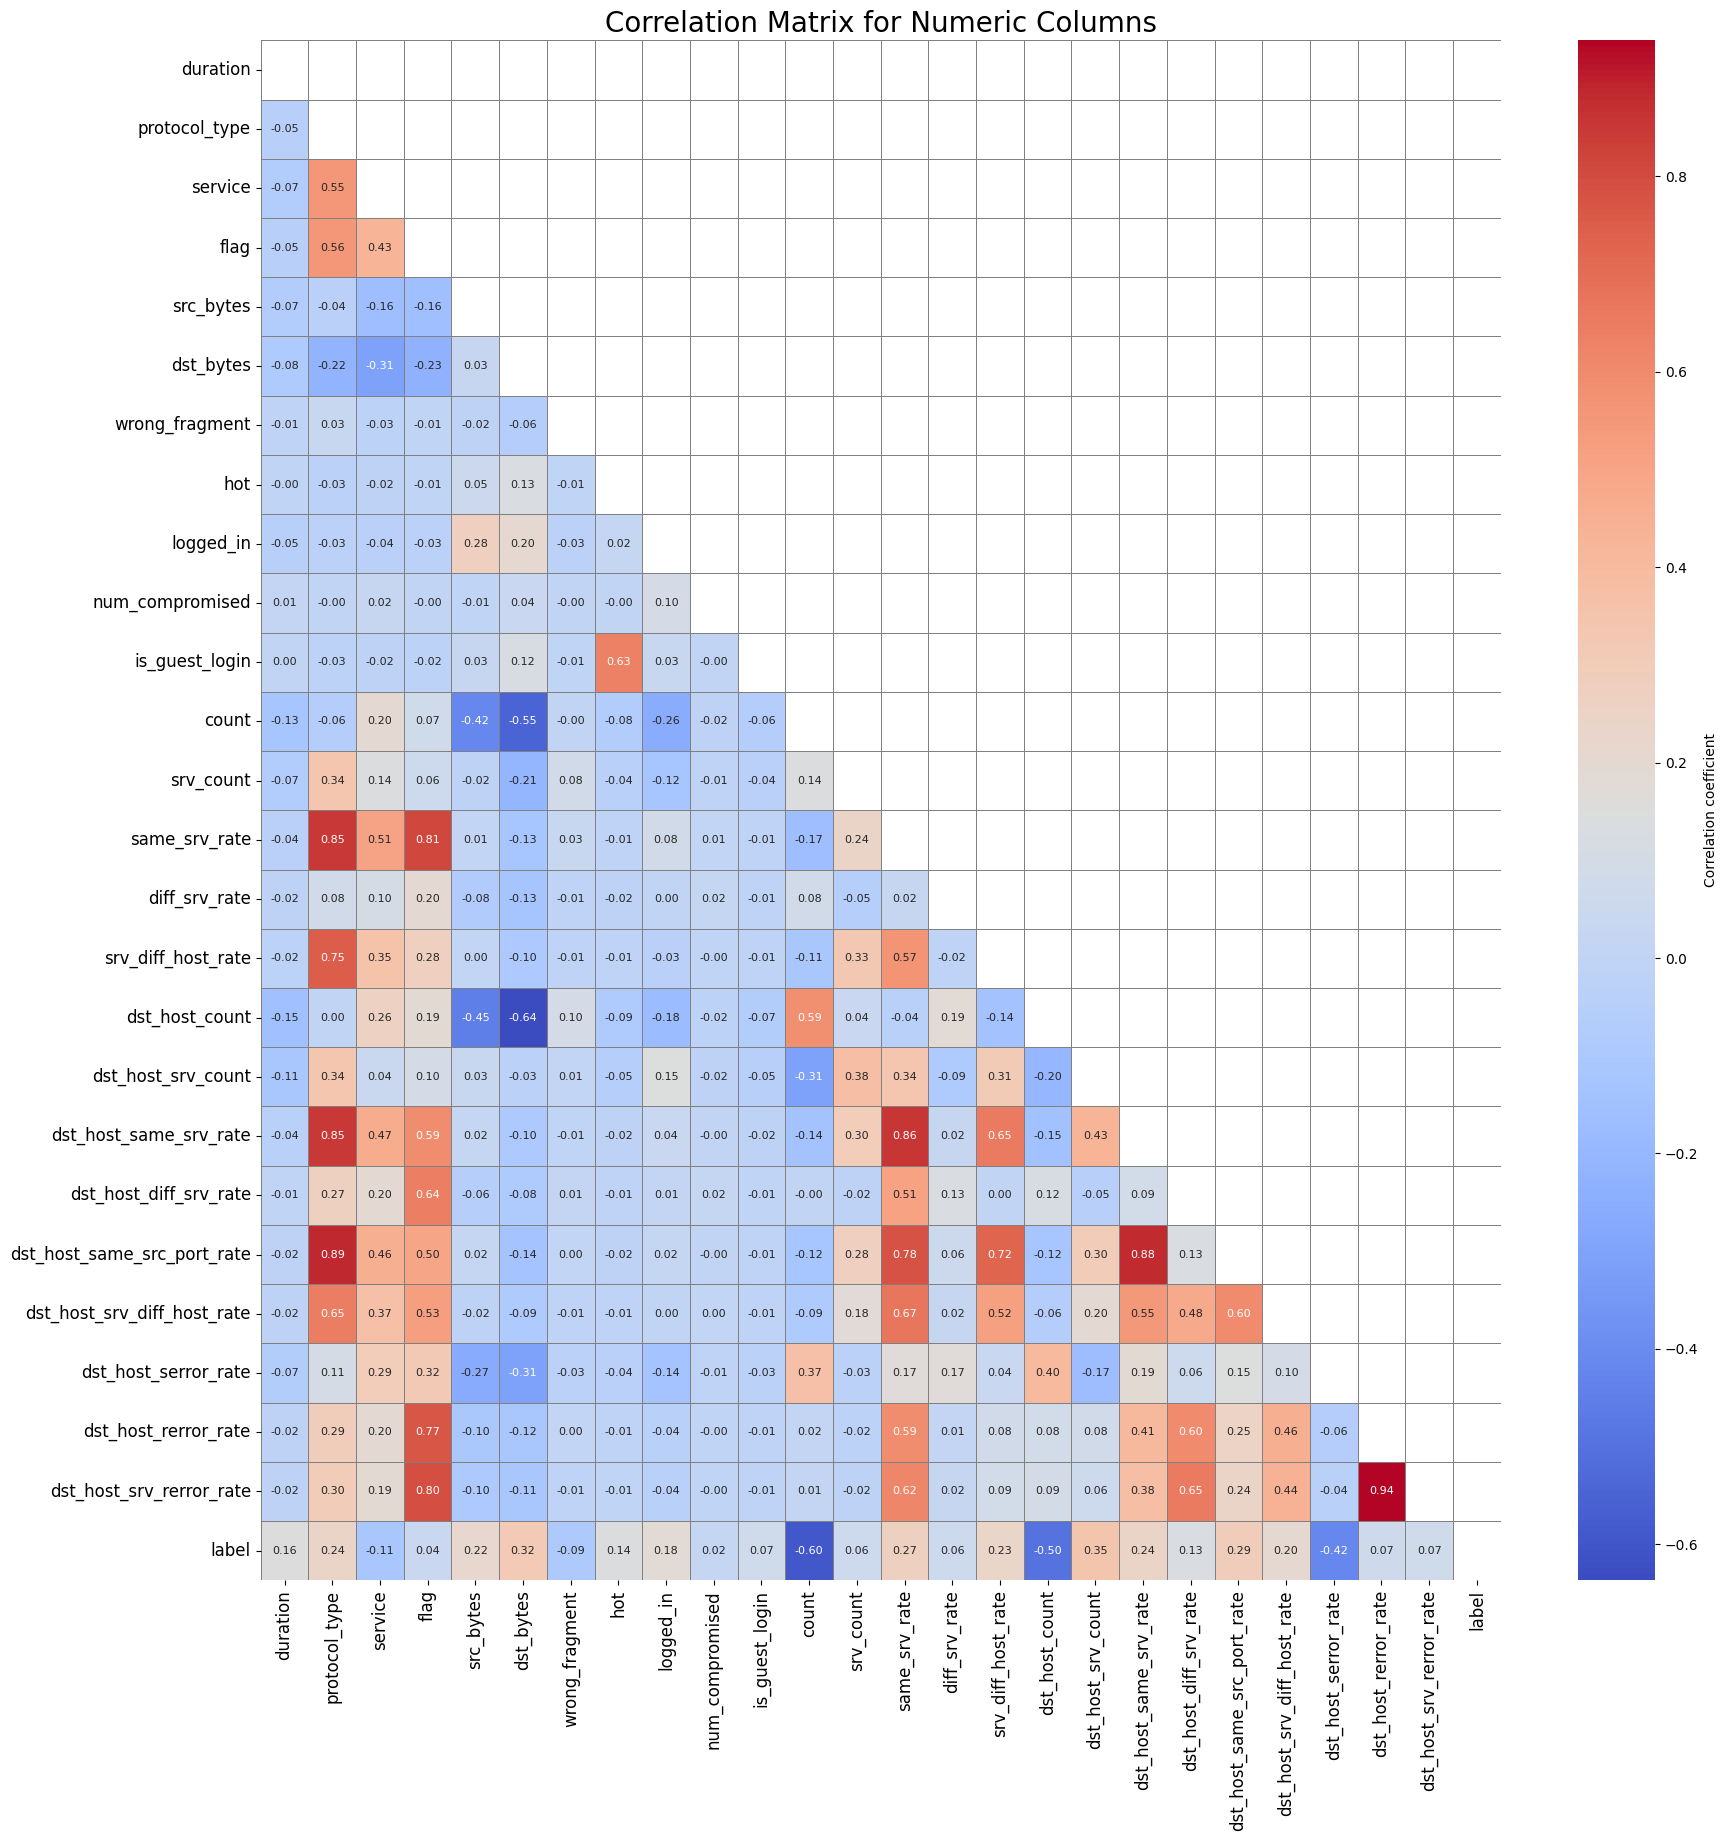

In [10]:
# 计算相关矩阵
correlation_matrix = df1.corr()

# 设置绘图尺寸
plt.figure(figsize=(20, 20))

# 设置颜色映射
# cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 生成上三角掩码
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 绘制热力图
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8}, cbar_kws={'label': 'Correlation coefficient'}, linewidths=0.5, linecolor='gray')

# 设置标题和标签
plt.title('Correlation Matrix for Numeric Columns', fontsize=20)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# 显示图像
plt.show()

In [11]:
y = df1['label']
X = df1.drop(['label'], axis=1)


# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled, y_resampled = X, y

print(f"Resampled dataset shape: {pd.Series(y_resampled).value_counts()}")

Resampled dataset shape: label
1    67343
0    45927
2    11656
3      995
4       52
Name: count, dtype: int64


In [12]:
# check for Nan values and replace them with 0
X = X_resampled.replace([np.inf, -np.inf],np.nan).fillna(0)
# X = X.drop(['level'], axis=1)

In [13]:
# 标准化
scaler = StandardScaler()

X_scaler = scaler.fit_transform(X)

X_scaler_df = pd.DataFrame(X_scaler, columns=X.columns)

In [14]:
# select features with high variance 除去常量特征即方差为0的特征
selector = VarianceThreshold(threshold=0)

selector.fit(X_scaler_df)

non_counstant_indices = selector.get_support(indices=True)

X_non_counstant = X_scaler_df.iloc[:, non_counstant_indices]

In [15]:
# select bast features with  ANOVA F 
# ANOVA F 统计量，它用于评估每个特征与目标变量 y 之间的线性关系。
k_bast = SelectKBest(score_func=f_classif ,k=20)
X_new = k_bast.fit_transform(X_non_counstant, y)

# 获取选择出的特征的列名
X_non_counstant.columns[k_bast.get_support()]


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'hot', 'logged_in', 'is_guest_login', 'count',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate'],
      dtype='object')

In [16]:
selected_features_name = X_non_counstant.columns[k_bast.get_support()]

X_selected = pd.DataFrame(X_new, columns=selected_features_name)

# PCA

In [17]:
pca = PCA()

pca.fit(X_selected)

explained_variance_ratio = pca.explained_variance_ratio_

In [18]:
explained_variance_ratio.cumsum()

array([0.28861495, 0.44546176, 0.52869978, 0.60186423, 0.65935225,
       0.70981831, 0.75733405, 0.80037602, 0.84145283, 0.87573644,
       0.90314882, 0.92593367, 0.94492092, 0.96312427, 0.97725585,
       0.98752962, 0.99287881, 0.99644597, 0.99885289, 1.        ])

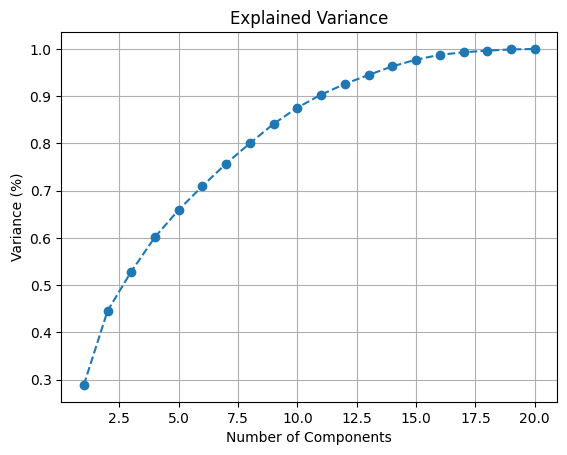

In [19]:
# 绘制累积解释方差比例的图表，以帮助确定保留多少个主成分。
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.grid(True)
plt.show()

In [20]:
n_components = 10

pca = PCA(n_components=n_components)

X_pca = pca.fit_transform(X_selected)

X_pca_df = pd.DataFrame(X_pca, columns=[ f'PC{i}' for i in range(n_components)])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'PC0'),
  Text(0, 1.5, 'PC1'),
  Text(0, 2.5, 'PC2'),
  Text(0, 3.5, 'PC3'),
  Text(0, 4.5, 'PC4'),
  Text(0, 5.5, 'PC5'),
  Text(0, 6.5, 'PC6'),
  Text(0, 7.5, 'PC7'),
  Text(0, 8.5, 'PC8'),
  Text(0, 9.5, 'PC9')])

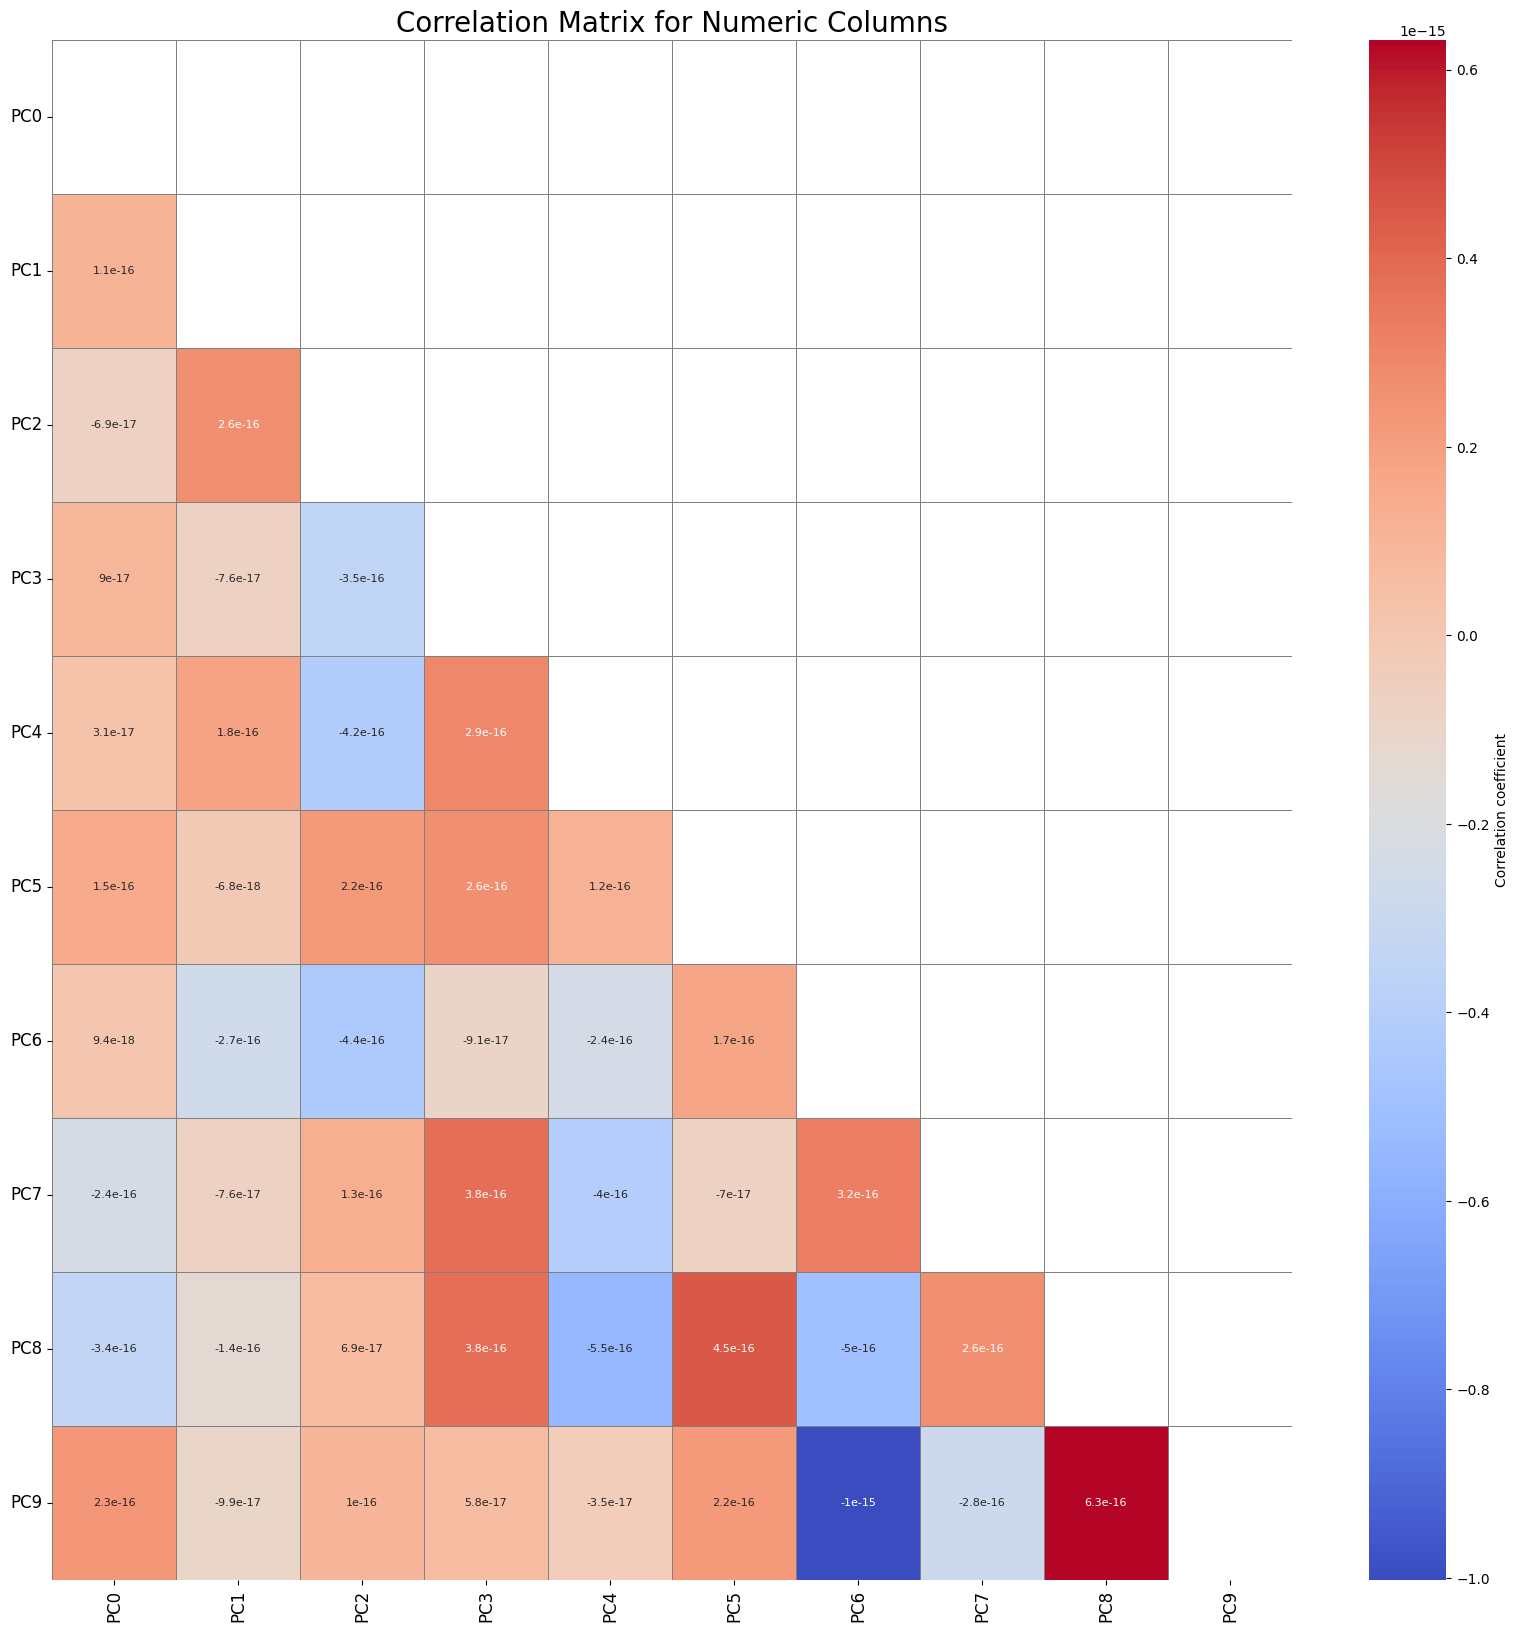

In [21]:
# 计算相关矩阵
correlation_matrix = X_pca_df.corr()

# 设置绘图尺寸
plt.figure(figsize=(20, 20))

# 设置颜色映射
# cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 生成上三角掩码
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 绘制热力图
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, annot_kws={"size": 8}, cbar_kws={'label': 'Correlation coefficient'}, linewidths=0.5, linecolor='gray')

# 设置标题和标签
plt.title('Correlation Matrix for Numeric Columns', fontsize=20)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Classify Model def

In [22]:


class Model:
    global y
    def __init__(self, data):
        self.data = data
        # X = preprocessing.StandardScaler().fit(self.data).transform(self.data)
        X = self.data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=42, test_size=0.3)  
    
    # 计算混淆矩阵
    def print_confusion_matrix(self, predicted):
        cm = confusion_matrix(self.y_test, predicted)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(self.y_test))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

    def LogisticRegression(self):
        solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

        start_time = time.time()
        results_lr = []
        accuracy_list = []
        for solver in solvers:
            LR = LogisticRegression(C=0.03, solver=solver).fit(self.X_train, self.y_train)
            predicted_lr = LR.predict(self.X_test)
            accuracy_lr = accuracy_score(self.y_test, predicted_lr)
            #print("Accuracy: %.2f%%" % (accuracy_lr * 100.0))
            #print('################################################################')
            results_lr.append({'solver' : solver, 'accuracy': str(round(accuracy_lr * 100, 2)) + "%", 
                                  'Coefficients': {'W' : LR.coef_, 'b': LR.intercept_}})
            
            accuracy_list.append(accuracy_lr)
       
        solver_name = solvers[accuracy_list.index(max(accuracy_list))]
        LR = LogisticRegression(C=0.03, solver=solver_name).fit(self.X_train,self.y_train)
        predicted_lr = LR.predict(self.X_test)
        accuracy_lr = accuracy_score(self.y_test, predicted_lr)
        print("Accuracy: %.2f%%" % (accuracy_lr * 100.0), '\n')
        print("########################################################################")
        print('Best solver is : ', solver_name)
        print("########################################################################")
        print(classification_report(predicted_lr, self.y_test), '\n')

        self.print_confusion_matrix(predicted_lr)

        print("########################################################################")
        print("--- %s seconds --- time for LogisticRegression" % (time.time() - start_time))
        
        return LR
        
    def SupportVectorMachine(self):
        start_time = time.time()
        accuracy_list = []
        result_svm = []
        kernels = ['linear', 'poly','rbf', 'sigmoid']
        #kernels = ['rbf']
        for kernel in kernels:
            SVM = svm.SVC(kernel=kernel).fit(self.X_train, self.y_train)
            predicted_svm = SVM.predict(self.X_test)
            accuracy_svm = accuracy_score(self.y_test, predicted_svm)
            result_svm.append({"kernel" : kernel, "accuracy": f"{round(accuracy_svm*100,2)}%"})
            print("Accuracy: %.2f%%" % round((accuracy_svm * 100.0),2))
            print('######################################################################')
            accuracy_list.append(accuracy_svm)
        
        kernel_name = kernels[accuracy_list.index(max(accuracy_list))]
        SVM = svm.SVC(kernel=kernel_name).fit(self.X_train, self.y_train)
        predicted_svm = SVM.predict(self.X_test)
        accuracy_svm = accuracy_score(self.y_test, predicted_svm)
        print(f"Accuracy of SVM model {round(accuracy_svm,2)*100}%", '\n')
        print("########################################################################")
        print('best kernel is : ', kernel_name)
        print("########################################################################")
        print(classification_report(predicted_svm, self.y_test))

        self.print_confusion_matrix(predicted_svm)

        print("########################################################################")
        print("--- %s seconds ---" % (time.time() - start_time))
        return SVM

    def KNearetsNeighbor(self):
        start_time = time.time()
        Ks = 12
        accuracy_knn = np.zeros((Ks-1))
        std_acc = np.zeros((Ks-1))
        #print(accuracy_knn)
        for n in range(1,Ks):

            #Train Model and Predict  
            neigh = KNeighborsClassifier(n_neighbors = n).fit(self.X_train,self.y_train)
            yhat=neigh.predict(self.X_test)
            accuracy_knn[n-1] = metrics.accuracy_score(self.y_test, yhat)


            std_acc[n-1]=np.std(yhat==self.y_test)/np.sqrt(yhat.shape[0])

        #print(accuracy_knn,'\n\n') # courseranyn ozinde tek osy gana jazylyp turdy
        #print(std_acc)
        #accuracy_knn[0] = 0
        plt.figure(figsize=(10,6))
        plt.plot(range(1,Ks),accuracy_knn,'g')
        plt.fill_between(range(1,Ks),accuracy_knn - 1 * std_acc,accuracy_knn + 1 * std_acc, alpha=0.10)
        plt.fill_between(range(1,Ks),accuracy_knn - 3 * std_acc,accuracy_knn + 3 * std_acc, alpha=0.10,color="green")
        plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
        plt.ylabel('Accuracy ')
        plt.xlabel('Number of Neighbors (K)')
        plt.tight_layout()
        plt.show()
        
        
        knnc = KNeighborsClassifier()
        knnc_search = GridSearchCV(knnc, param_grid={'n_neighbors': [2, 4, 6],
                                             'weights': ['uniform', 'distance'],
                                             'metric': ['euclidean', 'manhattan']},
                           n_jobs=1, cv=3, scoring='accuracy', verbose=2)
        
        knnc_search.fit(self.X_train, self.y_train)
        #print(knnc_search.best_params_)
        #print(knnc_search.best_score_)
        n_neighbors = knnc_search.best_params_['n_neighbors']
        weights = knnc_search.best_params_['weights']
        metric = knnc_search.best_params_['metric']
        KNN = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights).fit(self.X_train,self.y_train)
        
        predicted_knn = KNN.predict(self.X_test)
        accuracy_knn = metrics.accuracy_score(self.y_test, predicted_knn)
        print(f"Accuracy of KNN model {round(accuracy_knn,2)*100}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_knn, self.y_test))

        
        self.print_confusion_matrix(predicted_knn)

        print("########################################################################")
        print("--- %s seconds ---" % (time.time() - start_time))

        return KNN
        
    def DecisionTree(self):
        start_time = time.time()
        tree = DecisionTreeClassifier()
        dt_search = GridSearchCV(tree, param_grid={'criterion' : ['gini', 'entropy'],
                                           'max_depth' : [2,3,4,5,6,7,8, 9, 10],
                                           'max_leaf_nodes' : [2,3,4,5,6,7,8,9,10, 11]},
                           n_jobs=1, cv=5, scoring='accuracy', verbose=2)
        
        dt_search.fit(self.X_train, self.y_train)
        
        criterion = dt_search.best_params_['criterion']
        max_depth = dt_search.best_params_['max_depth']
        max_leaf_nodes = dt_search.best_params_['max_leaf_nodes']
        
        dtree = DecisionTreeClassifier(criterion=criterion, 
                                       max_depth=max_depth, 
                                       max_leaf_nodes=max_leaf_nodes).fit(self.X_train, self.y_train)
        predicted_dt = dtree.predict(self.X_test)
        accuracy_dt = metrics.accuracy_score(self.y_test, predicted_dt)
        print(f"criterion: {criterion}, max depth: {max_depth}, max_leaf: {max_leaf_nodes}")
        print(f"The Accuracy is : {round(accuracy_dt * 100,2)}%")
        print("########################################################################")
        print(classification_report(predicted_dt, self.y_test))
        self.print_confusion_matrix(predicted_dt)
        print("########################################################################")
        
        print("--- %s seconds ---" % (time.time() - start_time))

        return dtree
    
    def RandomForest(self):
        start_time = time.time()
        RF = RandomForestClassifier(criterion='gini', 
                                     n_estimators=500,
                                     min_samples_split=10,
                                     #min_samples_leaf=1,
                                     # max_features='auto',
                                     oob_score=True,
                                     random_state=1,
                                     n_jobs=1).fit(self.X_train, self.y_train)
        
        predicted_rf = RF.predict(self.X_test)
        svm_accuracy = accuracy_score(self.y_test, predicted_rf)
        print(f"Accuracy of RF is : {round(svm_accuracy*100,2)}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_rf, self.y_test))
        self.print_confusion_matrix(predicted_rf)
        print("########################################################################")
        
        print("--- %s seconds ---" % (time.time() - start_time))

        return RF
    
"""
Decision Tree works Well
Suppert Vector Machine works well
Logistic Regression works well
KNN works well
Random Forest works well
"""

'\nDecision Tree works Well\nSuppert Vector Machine works well\nLogistic Regression works well\nKNN works well\nRandom Forest works well\n'

In [23]:
# run classify model

In [24]:
X = pd.get_dummies(X_pca_df)
M = Model(X)

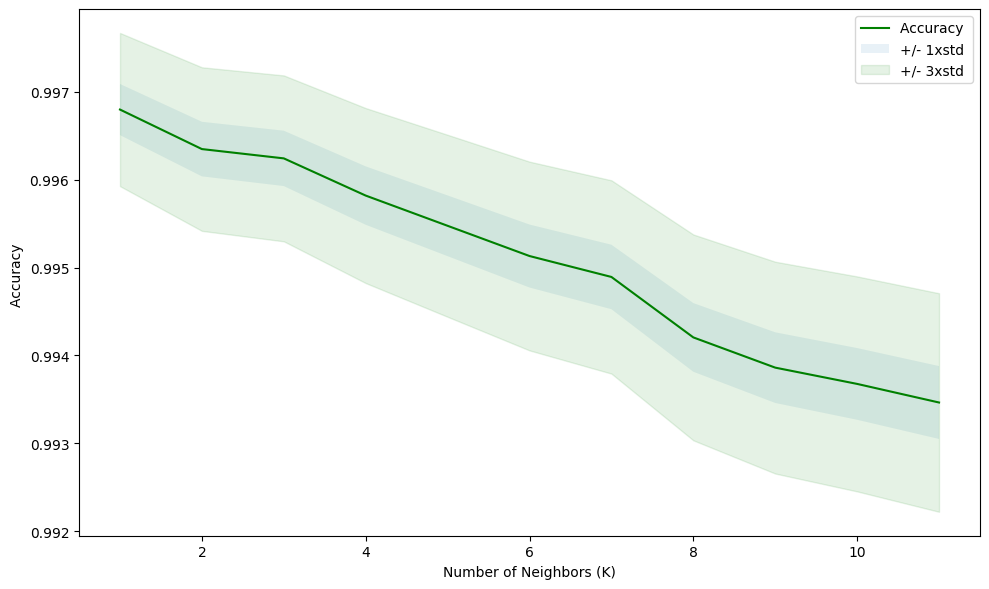

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   1.2s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   1.3s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   1.3s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   1.2s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   1.1s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   1.2s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.5s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.5s
[CV] END ..metric=euclidean, n_neighbors=4, weig

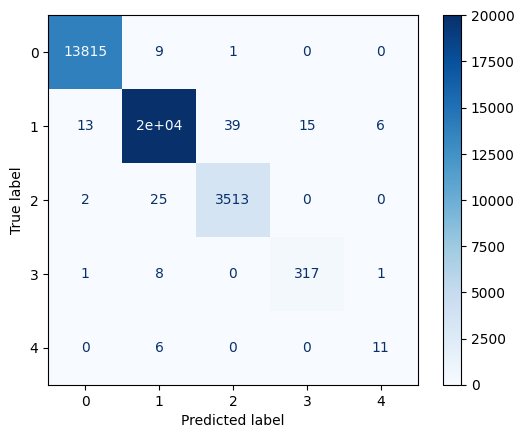

########################################################################
--- 59.91895413398743 seconds ---


In [25]:
knn = M.KNearetsNeighbor()

Accuracy: 92.76% 

########################################################################
Best solver is :  lbfgs
########################################################################
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     13647
           1       0.97      0.91      0.94     21534
           2       0.65      0.89      0.75      2575
           3       0.01      0.11      0.02        36
           4       0.00      0.00      0.00         0

    accuracy                           0.93     37792
   macro avg       0.52      0.58      0.54     37792
weighted avg       0.94      0.93      0.93     37792
 



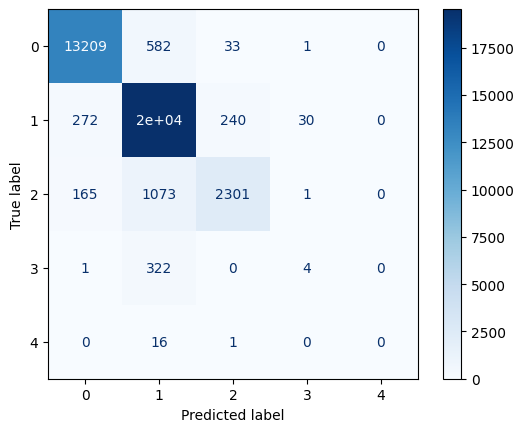

########################################################################
--- 20.291674852371216 seconds --- time for LogisticRegression


In [26]:
lr = M.LogisticRegression()

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.4s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.4s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=4; total time=   0.4s
[CV] END ......criterion=gini, max_depth=2, ma

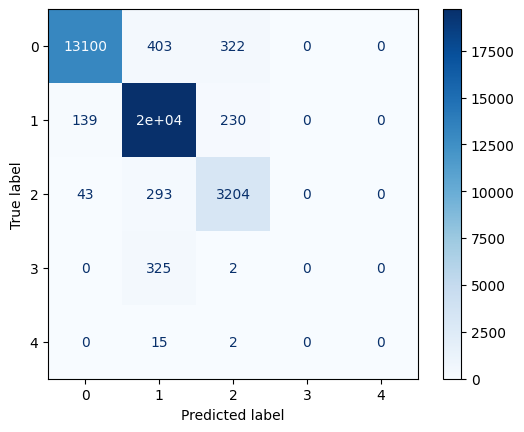

########################################################################
--- 784.75195145607 seconds ---


In [27]:
dTree = M.DecisionTree()

Accuracy of RF is : 99.59% 

########################################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13816
           1       1.00      0.99      1.00     20144
           2       0.99      0.99      0.99      3522
           3       0.93      0.99      0.96       306
           4       0.24      1.00      0.38         4

    accuracy                           1.00     37792
   macro avg       0.83      1.00      0.86     37792
weighted avg       1.00      1.00      1.00     37792



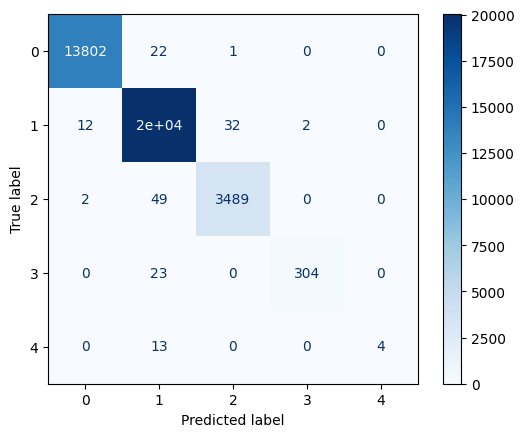

########################################################################
--- 404.4842200279236 seconds ---


In [28]:
rf = M.RandomForest()

Accuracy: 93.38%
######################################################################
Accuracy: 96.26%
######################################################################
Accuracy: 96.72%
######################################################################
Accuracy: 82.20%
######################################################################
Accuracy of SVM model 97.0% 

########################################################################
best kernel is :  rbf
########################################################################
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13549
           1       0.99      0.95      0.97     20779
           2       0.87      0.96      0.91      3191
           3       0.78      0.93      0.85       273
           4       0.00      0.00      0.00         0

    accuracy                           0.97     37792
   macro avg       0.72      0.77      0.74     37792
weighted avg    

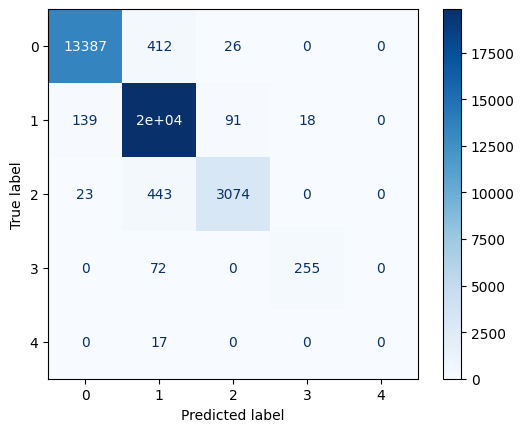

########################################################################
--- 367.7297978401184 seconds ---


In [29]:
svm = M.SupportVectorMachine()

# Validation model

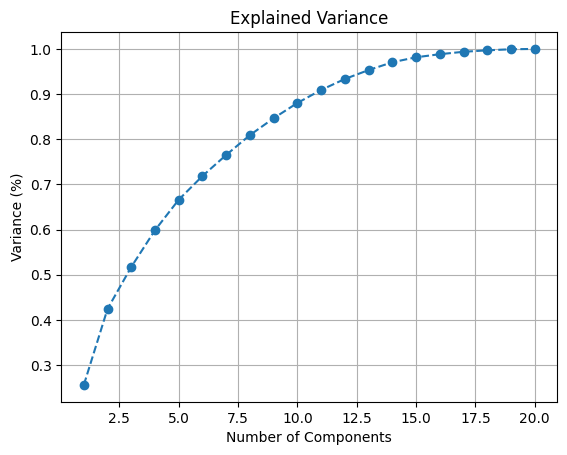

In [30]:

df = test

df2 =  df.dropna()
df2.columns = df2.columns.str.strip()
    # 处理数据中的字符值
label_encoder = LabelEncoder()
object_cols = df2.select_dtypes(include=['object']).columns

for col in object_cols:
    print(f"{col}: {df2[col].dtype}")
    df2[col] = label_encoder.fit_transform(df2[col])

y = df2['label']
X = df2.drop(['label'], axis=1)


    # rus = RandomUnderSampler(random_state=42)
    # X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled, y_resampled = X, y

# y = y_resampled

X = X_resampled.replace([np.inf, -np.inf],np.nan).fillna(0)
# X = X.drop(['level'], axis=1)  

    # 标准化
scaler = StandardScaler()

X_scaler = scaler.fit_transform(X)

X_scaler_df = pd.DataFrame(X_scaler, columns=X.columns)

# select features with high variance 除去常量特征即方差为0的特征
selector = VarianceThreshold(threshold=0)

selector.fit(X_scaler_df)

non_counstant_indices = selector.get_support(indices=True)

X_non_counstant = X_scaler_df.iloc[:, non_counstant_indices]

# select bast features with  ANOVA F 
# ANOVA F 统计量，它用于评估每个特征与目标变量 y 之间的线性关系。
k_bast = SelectKBest(score_func=f_classif ,k=20)
X_new = k_bast.fit_transform(X_non_counstant, y)

# 获取选择出的特征的列名
X_non_counstant.columns[k_bast.get_support()]

selected_features_name = X_non_counstant.columns[k_bast.get_support()]

X_selected = pd.DataFrame(X_new, columns=selected_features_name)

pca = PCA()

pca.fit(X_selected)

explained_variance_ratio = pca.explained_variance_ratio_

# 绘制累积解释方差比例的图表，以帮助确定保留多少个主成分。
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.grid(True)
plt.show()

n_components = 10

pca = PCA(n_components=n_components)

X_pca = pca.fit_transform(X_selected)

X_pca_df_test = pd.DataFrame(X_pca, columns=[ f'PC{i}' for i in range(n_components)])




In [31]:
def validate_model(model, X, y):
    predicted = model.predict(X)
    accuracy  = metrics.accuracy_score(y, predicted)
    print(f"Accuracy of { model.__class__.__name__ } ismodel {round(accuracy,2)*100}%", '\n')
    print("########################################################################")
    print(classification_report(predicted, y))
    cm = confusion_matrix(y, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()



In [32]:
classifiers = {
    'Random Forest': rf,
    'Logistic Regression':  lr,
    'Support Vector Machine': svm,
    'K-Nearest Neighbors':  knn,
    'Decision Tree':  dTree,
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, classifier in  classifiers.items():
    scores = cross_val_score(classifier, X_pca_df_test, y, cv=cv, scoring='accuracy')
    print(f'{name} Accuracy: {(round(scores.mean(),4) * 100)}%')
    print(f'{name} Accuracy Standard Deviation: {scores.std():.2f}')
    print(f'scores: {scores}')
    print('----------------------------------------------------')

Random Forest Accuracy: 97.42%
Random Forest Accuracy Standard Deviation: 0.00
scores: [0.97338656 0.97161233 0.9740519  0.97870925 0.97338066]
----------------------------------------------------
Logistic Regression Accuracy: 82.13000000000001%
Logistic Regression Accuracy Standard Deviation: 0.00
scores: [0.81902861 0.82390774 0.81525837 0.82767798 0.82054126]
----------------------------------------------------
Support Vector Machine Accuracy: 93.0%
Support Vector Machine Accuracy Standard Deviation: 0.00
scores: [0.93501885 0.92636948 0.92969616 0.93013972 0.92879326]
----------------------------------------------------
K-Nearest Neighbors Accuracy: 97.47%
K-Nearest Neighbors Accuracy Standard Deviation: 0.00
scores: [0.97493901 0.97116877 0.97471723 0.97760035 0.97515528]
----------------------------------------------------
Decision Tree Accuracy: 87.07000000000001%
Decision Tree Accuracy Standard Deviation: 0.01
scores: [0.8700377  0.87779996 0.86316256 0.86626747 0.87599823]
---